In [1]:
import pandas as pd
import numpy as np
import SimpleITK as sitk
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose, RandomApply, RandomHorizontalFlip, RandomRotation
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
data_dir = r'inputs/shared/brain_age/'

meta_data = pd.read_csv(data_dir + 'meta/meta_data_all.csv')

In [10]:
#registration
def registration(fixed_image, moving_image):

    # Create an instance of ImageRegistrationMethod
    registration = sitk.ImageRegistrationMethod()

    # Set the metric as correlation and specify optimizer parameters
    registration.SetMetricAsCorrelation()
    registration.SetOptimizerAsRegularStepGradientDescent(learningRate=5.0,
                                           minStep=1e-4,
                                           numberOfIterations=20,
                                           gradientMagnitudeTolerance=1e-8)

    # Set optimizer scales based on index shift
    registration.SetOptimizerScalesFromIndexShift()

    # Calculate an initial transformation for geometric alignment
    initialization = sitk.CenteredTransformInitializer(fixed_image, 
                                              moving_image, 
                                              sitk.AffineTransform(3), 
                                              sitk.CenteredTransformInitializerFilter.GEOMETRY)

    # Set the initial transform and interpolator
    registration.SetInitialTransform(initialization)
    registration.SetInterpolator(sitk.sitkLinear)

    # Execute the registration process
    output= registration.Execute(fixed_image, moving_image)
    
    return output  # Return the transformation

def resample_image(reference, floating,transformation):
    res = sitk.ResampleImageFilter()
    res.SetReferenceImage(reference)
    res.SetInterpolator(sitk.sitkLinear)
    res.SetDefaultPixelValue(0)

    res.SetTransform(transformation)
    return res.Execute(floating)

In [ ]:
import os
output_directory=data_dir+'/registered_1'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
all_subject_ids=meta_df['subject_id']
image_filenames=[data_dir + 'MRI_all/sub-' + f + '_T1w_unbiased.nii.gz' for f in all_subject_ids]
fixed_image=image_filenames[0]
fixed_image=sitk.ReadImage(fixed_image)
for idx,filename in enumerate(image_filenames[1:]):
    moving_image=sitk.ReadImage(filename)
    transf = registration(moving_image,fixed_image)
    registered_image=resample_image(img, sitk_atlas, transformation = transf)
    sitk.WriteImage(registered_image, os.path.join(output_directory, f"registered_{idx}.nii.gz"))

In [8]:
#data preprocesing pipeline

class ImagePreprocessor:
    def normalize(image, mask):
        #normalizes image using mask
        img_array = sitk.GetArrayFromImage(image).astype(np.float32)
        msk_array = sitk.GetArrayFromImage(mask)

        mean = np.mean(img_array[msk_array > 0])
        std = np.std(img_array[msk_array > 0])

        if std > 0:
            img_array = (img_array - mean) / std
            img_array[msk_array == 0] = 0

        image_normalised = sitk.GetImageFromArray(img_array)
        image_normalised.CopyInformation(image)

        return image_normalised

    def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
        #Resamples an image to given element spacing and output size
        original_spacing = np.array(image.GetSpacing())
        original_size = np.array(image.GetSize())

        if out_size is None:
            out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
        else:
            out_size = np.array(out_size)

        original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
        original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
        out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

        original_center = np.matmul(original_direction, original_center)
        out_center = np.matmul(original_direction, out_center)
        out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(out_spacing)
        resample.SetSize(out_size.tolist())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(out_origin.tolist())
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(pad_value)

        if is_label:
            resample.SetInterpolator(sitk.sitkNearestNeighbor)
        else:
            resample.SetInterpolator(sitk.sitkBSpline)

        return resample.Execute(image)
class MRIDataset(Dataset):

    def __init__(self, file_list_img,file_list_msk,gen_data, labels, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.labels = labels
        self.gen_data = gen_data
        
        # Define your data augmentation transforms
        self.transforms = Compose([
            RandomRotation(degrees=90),
            RandomHorizontalFlip(p=0.5),
        ])

        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            msk_path = file_list_msk[idx]
            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = ImagePreprocessor.normalize(img, msk)
            img = ImagePreprocessor.resample_image(img, img_spacing, img_size, is_label=False)
            sample = {'image':img, 'age': labels[idx], 'gender':gen_data[idx]}
            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]
        image = torch.from_numpy(sitk.GetArrayFromImage(sample['image'])).unsqueeze(0)
        image_transformed = self.transforms(image)
        return {'image': image_transformed, 'age': sample['age'], 'gender': sample['gender']}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]


In [4]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu") 

img_size = [64,64,64]
img_spacing = [3, 3, 3]

num_epochs = 20
learning_rate = 0.0001
weight_decay = 8.487363687711162e-05
out_dir = './output'

In [6]:
# 500 training dataset
dataframe = pd.read_csv(data_dir + 'meta/meta_data_all.csv')

meta_data_reg, temp_df = train_test_split(dataframe, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Reset the index
meta_data_reg = meta_data_reg.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


ids_reg_train = list(meta_data_reg['subject_id'])
gen_data_train = list(meta_data_reg['gender_code'])

reg_data_labels = meta_data_reg['age']
files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_train]
meta_data_reg_test = test_df
ids_reg_test = list(meta_data_reg_test['subject_id'])
gen_data_test = list(meta_data_reg_test['gender_code'])

reg_data_test_labels = meta_data_reg_test['age']
files_reg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_test]
meta_data_reg_val = val_df
ids_reg_val = list(meta_data_reg_val['subject_id'])
gen_data_val = list(meta_data_reg_val['gender_code'])

reg_data_val_labels = meta_data_reg_val['age']
files_reg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_val]
# printing all datasets length
print("Training : Data and labels (shape): ",len(files_reg_img_train), len(files_seg_msk_train), reg_data_labels.shape)
print("Testing :Data and labels (shape): ",len(files_reg_img_test), len(files_seg_msk_test), reg_data_test_labels.shape)
print("Val :Data and labels (shape): ",len(files_reg_img_val), len(files_seg_msk_val), reg_data_val_labels.shape)

Training : Data and labels (shape):  521 521 (521,)
Testing :Data and labels (shape):  66 66 (66,)
Val :Data and labels (shape):  65 65 (65,)


In [9]:
# LOAD TRAINING DATA
dataset = MRIDataset(files_reg_img_train, files_seg_msk_train, gen_data_train,reg_data_labels, img_spacing, img_size)

# LOAD VALIDATION DATA
dataset_val = MRIDataset(files_reg_img_val, files_seg_msk_val,gen_data_val, reg_data_val_labels, img_spacing, img_size)

# LOAD TEST DATA
dataset_test = MRIDataset(files_reg_img_test, files_seg_msk_test,gen_data_test, reg_data_test_labels, img_spacing, img_size)


print("Training data before augumentation:")
print(len(dataset))

Loading Data: 100%|████████████████████████████████████████████████████████████████████| 66/66 [00:17<00:00,  3.76it/s]

Training data before augumentation:
521


In [23]:
dataloader_train = torch.utils.data.DataLoader(dataset, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, shuffle=False)

In [24]:
class MRIAgePredictionNet(nn.Module):
    def __init__(self):
        super(MRIAgePredictionNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2),

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2),

            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2),

            nn.Conv3d(256, 512, kernel_size=3, padding=1), # this one
            nn.BatchNorm3d(512),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2),

            nn.Conv3d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=2),

        )
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [26]:
# !pip install torchinfo
from torchinfo import summary
model = MRIAgePredictionNet()

+ TRAINING 	Epoch: 1 	Loss: 17.45189956328233
+ VALIDATION 	Epoch: 1 	Loss: 13.38991705087515
+ TRAINING 	Epoch: 2 	Loss: 10.753620180653519
+ VALIDATION 	Epoch: 2 	Loss: 10.994016735370343
+ TRAINING 	Epoch: 3 	Loss: 9.827467868973335
+ VALIDATION 	Epoch: 3 	Loss: 10.48625224186824
+ TRAINING 	Epoch: 4 	Loss: 9.68320736729481
+ VALIDATION 	Epoch: 4 	Loss: 9.650613403320312
+ TRAINING 	Epoch: 5 	Loss: 9.395967424945502
+ VALIDATION 	Epoch: 5 	Loss: 10.86077502324031
+ TRAINING 	Epoch: 6 	Loss: 9.168811461289419
+ VALIDATION 	Epoch: 6 	Loss: 10.378889758770283
+ TRAINING 	Epoch: 7 	Loss: 8.803792704547435
+ VALIDATION 	Epoch: 7 	Loss: 20.302787311260516
+ TRAINING 	Epoch: 8 	Loss: 8.655954481772865
+ VALIDATION 	Epoch: 8 	Loss: 9.417544144850512
+ TRAINING 	Epoch: 9 	Loss: 8.378447475909272
+ VALIDATION 	Epoch: 9 	Loss: 10.509022874098557
+ TRAINING 	Epoch: 10 	Loss: 8.74708795455962
+ VALIDATION 	Epoch: 10 	Loss: 10.74779551579402
+ TRAINING 	Epoch: 11 	Loss: 7.886094483212638
+ VALIDA

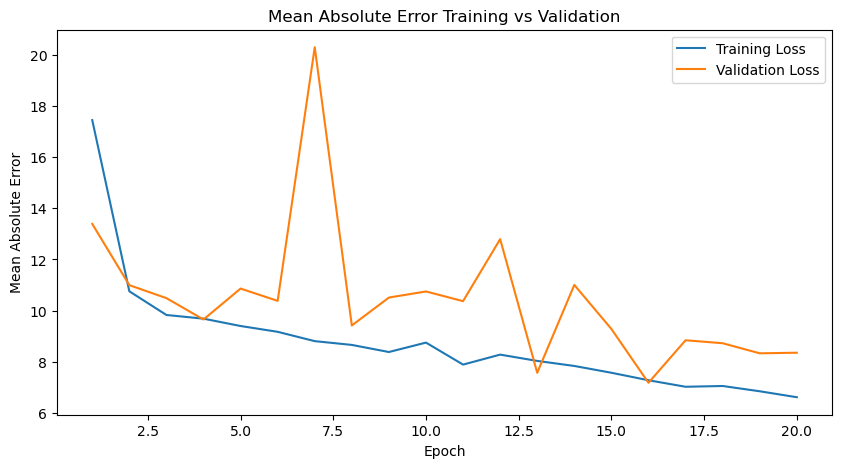

In [28]:
# Number of epochs

# Device configuration - defaults to CPU unless GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = MRIAgePredictionNet().to(device)
model.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
MAE = nn.L1Loss()

# Lists to store MAE of each epoch for training and validation
train_mae_list = []
val_mae_list = []

for epoch in range(1, num_epochs + 1):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    # Training loop
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, targets = batch_samples['image'].to(device), batch_samples['age'].to(device)
        optimizer.zero_grad()
        target_pred = model(img)
        targets = targets.view(-1, 1)
        loss = MAE(target_pred, targets)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch_idx, batch_samples in enumerate(dataloader_val):
            img, targets = batch_samples['image'].to(device), batch_samples['age'].to(device)
            target_pred = model(img)
            targets = targets.view(-1, 1)
            loss = MAE(target_pred, targets)
            val_epoch_loss += loss.item()

    model.train()

    print(f'+ TRAINING \tEpoch: {epoch} \tLoss: {train_epoch_loss / len(dataloader_train)}')
    print(f'+ VALIDATION \tEpoch: {epoch} \tLoss: {val_epoch_loss / len(dataloader_val)}')

    train_mae_list.append(train_epoch_loss / len(dataloader_train))
    val_mae_list.append(val_epoch_loss / len(dataloader_val))

print('\nFinished TRAINING.')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_mae_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_mae_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error Training vs Validation')
plt.legend()
plt.show()


In [29]:
model.eval()

# Initialize variables to store the total MAE and the number of samples
total_mae = 0
total_samples = 0

with torch.no_grad():
    for batch_idx, batch_samples in enumerate(dataloader_test):
        img, targets = batch_samples['image'].to(device), batch_samples['age'].to(device)
        targets = targets.view(-1, 1)
        target_pred = model(img)
        mae = torch.abs(target_pred - targets).sum()
        total_mae += mae.item()
        total_samples += targets.size(0)

# Calculate the average MAE
test_mae = total_mae / total_samples

print("Mean Absolute Error on test set: ", test_mae)

Mean Absolute Error on test set:  8.49222316163959
